# Premier Algorithme de Trading
## Trading de Paires

Le trading de paires est une stratégie qui utilise deux actions qui sont fortement corrélées. Nous pouvons alors utiliser la différence de prix entre les deux actions comme signal si l'une d'entre elles sort de la corrélation avec l'autre. Il s'agit d'une stratégie plus ancienne qui est utilisée classiquement comme guide pour commencer le trading algorithmique. Il existe un guide complet fantastique et vous pouvez le trouvez sur Investopedia [ici](http://www.investopedia.com/university/guide-pairs-trading/)! **Je vous recommande vivement de lire l'article dans son intégralité avant de continuer, il est divertissant et instructif !**


Créons notre premier algorithme de Trading base ! Il s'agit d'un exercice d'utilisation de l'algorithme quantique, **PAS** d'une représentation réaliste de ce qu'est un bon algorithme ! N'utilisez jamais quelque chose d'aussi simple que cela dans le monde réel ! Il s'agit d'une version extrêmement simplifiée du Trading de paires, nous ne prendrons pas en compte des facteurs tels que la co-intégration !

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## United Airlines et American Airlines

In [2]:
start = '07-01-2015'
end = '07-01-2017'

In [3]:
# en local
# united = quandl.get('WIKI/UAL',start_date=start,end_date=end)
# american = quandl.get('WIKI/AAL',start_date=start,end_date=end)

united = get_pricing('UAL',start_date=start,end_date=end)
american = get_pricing('AAL',start_date=start,end_date=end)

In [4]:
united.head()

,open_price,high,low,close_price,volume,price
2015-07-01 00:00:00+00:00,54.05,54.14,50.10,51.69,12129258.0,51.69
2015-07-02 00:00:00+00:00,51.88,52.51,50.98,51.48,4551677.0,51.48
2015-07-06 00:00:00+00:00,52.05,53.95,52.05,53.80,5458762.0,53.80
2015-07-07 00:00:00+00:00,53.99,54.49,52.54,54.25,5373987.0,54.25
2015-07-08 00:00:00+00:00,53.44,53.72,52.25,52.82,4050933.0,52.82


In [5]:
american.head()

,open_price,high,low,close_price,volume,price
2015-07-01 00:00:00+00:00,39.846,40.091,37.052,38.023,23439886.0,38.023
2015-07-02 00:00:00+00:00,38.248,39.018,37.640,38.253,10226556.0,38.253
2015-07-06 00:00:00+00:00,38.317,39.209,38.307,38.934,8025562.0,38.934
2015-07-07 00:00:00+00:00,39.140,39.934,38.483,39.865,9341995.0,39.865
2015-07-08 00:00:00+00:00,39.503,39.513,38.366,38.542,9976525.0,38.542


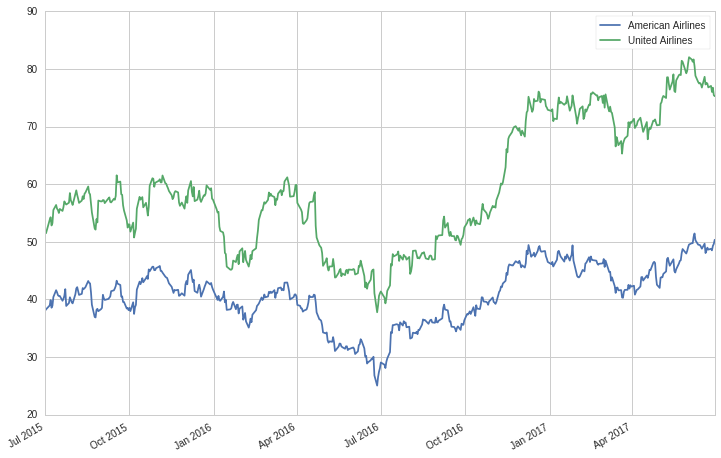

In [6]:
# american['Adj. Close'].plot(label='American Airlines',figsize=(12,8))
# united['Adj. Close'].plot(label='United Airlines')
american['close_price'].plot(label='American Airlines',figsize=(12,8))
united['close_price'].plot(label='United Airlines')
plt.legend()

## Dispersion et Corrélation

In [7]:
# np.corrcoef(american['Adj. Close'],united['Adj. Close'])
np.corrcoef(american['close_price'],united['close_price'])

array([[ 1.        ,  0.91653673],
       [ 0.91653673,  1.        ]])

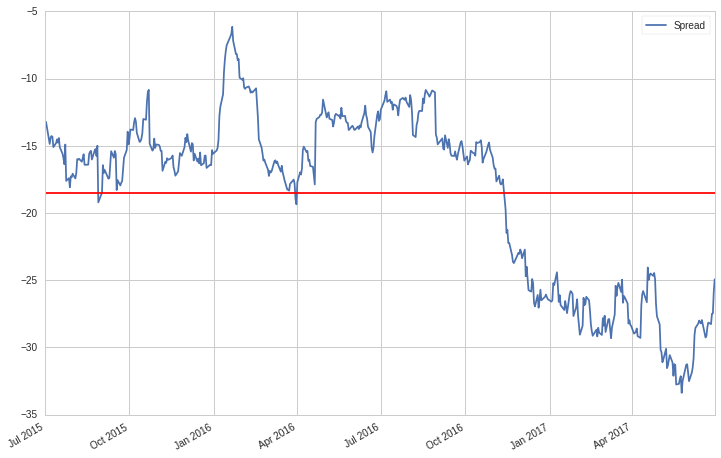

In [8]:
# spread = american['Adj. Close'] - united['Adj. Close']
spread = american['close_price'] - united['close_price']
spread.plot(label='Spread',figsize=(12,8))
plt.axhline(spread.mean(),c='r')
plt.legend()

### Normaliser avec un z-score

In [9]:
def zscore(stocks):
    return (stocks - stocks.mean()) / np.std(stocks)

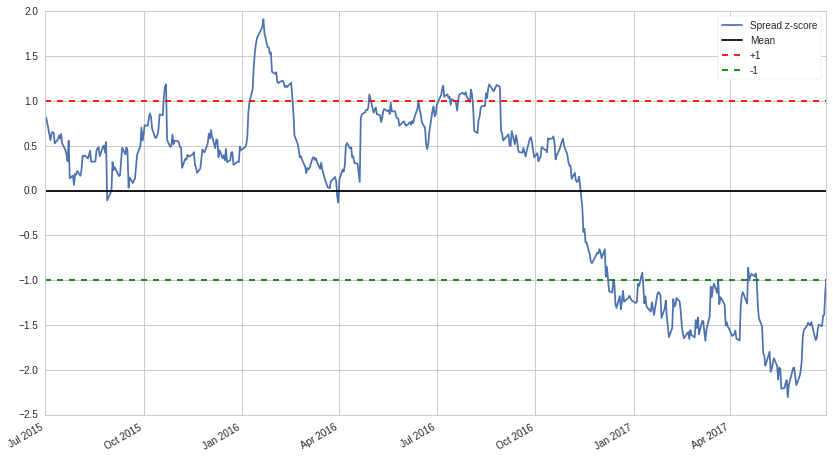

In [10]:
zscore(spread).plot(figsize=(14,8))
plt.axhline(zscore(spread).mean(), color='black')
plt.axhline(1.0, c='r', ls='--')
plt.axhline(-1.0, c='g', ls='--')
plt.legend(['Spread z-score', 'Mean', '+1', '-1']);

### Rolling Z-Score

Notre écart est actuellement American-United. Décidons de la façon de calculer ce spread sur une base continue pour notre utilisation en Quantopian

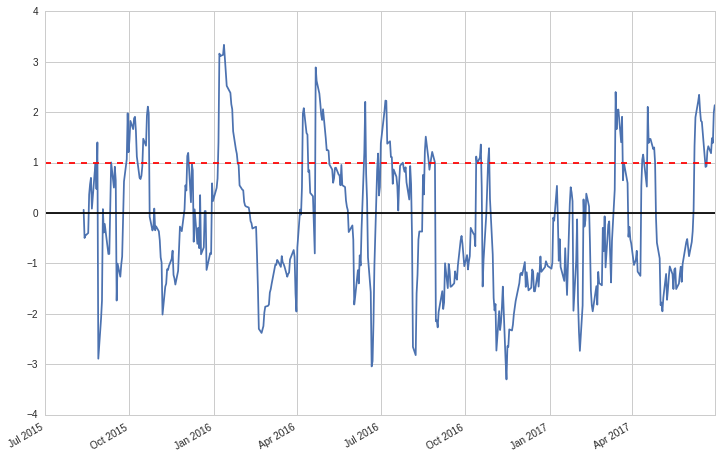

In [11]:
# Moyenne mobile sur 1 jour de l'écart de prix
spread_mavg1 = spread.rolling(1).mean()

# Moyenne mobile sur 30 jours de l'écart de prix
spread_mavg30 = spread.rolling(30).mean()

# Prendre un écart-type mobile de 30 jours
std_30 = spread.rolling(30).std()

# Calculer le z score pour chaque jour
zscore_30_1 = (spread_mavg1 - spread_mavg30)/std_30



zscore_30_1.plot(figsize=(12,8),label='Rolling 30 day Z score')
plt.axhline(0, color='black')
plt.axhline(1.0, color='red', linestyle='--');

## Implémentation de la Stratégie sur l'IDE Quantopian

#### AVERTISSEMENT : VOUS NE DEVEZ PAS FAIRE DE TRADING AVEC ÇA !

In [12]:
import numpy as np
 
def initialize(context):
    """
    Appelé une fois au début de l'algorithme.
    """   
    
    # Chaque jour, nous vérifions le status de la paire
    schedule_function(check_pairs, date_rules.every_day(), time_rules.market_close(minutes=60))
    
    # Nos 2 compagnies aériennes
    context.aa = sid(45971) #aal
    context.ual = sid(28051) #ual   
    
    # Flags pour nous dire si on est dans une position de Trading
    context.long_on_spread = False
    context.shorting_spread = False


def check_pairs(context, data):
    
    # Par commodité
    aa = context.aa
    ual = context.ual
    
    # Obtenir l'historique des prix
    prices = data.history([aa, ual], "price", 30, '1d')
    
 
    # Nécessité d'utiliser .iloc[-1 :] pour obtenir un dataframe au lieu de séries
    short_prices = prices.iloc[-1:]
    
    # Obtenir la moyenne mobile longue sur 30 jours
    mavg_30 = np.mean(prices[aa] - prices[ual])
    
    # Obtenez l'écart-type' de la fenêtre de 30 jours
    std_30 = np.std(prices[aa] - prices[ual])
    
    # Obtenir la moyenne mobile courte sur 30 jours
    mavg_1 = np.mean(short_prices[aa] - short_prices[ual])
    
    # Calculer le z-score
    if std_30 > 0:
        zscore = (mavg_1 - mavg_30)/std_30
    
        # Nos 2 cas d'entrée
        if zscore > 0.5 and not context.shorting_spread:
            # spread = aa - ual
            order_target_percent(aa, -0.5) # short top
            order_target_percent(ual, 0.5) # long bottom
            context.shorting_spread = True
            context.long_on_spread = False
            
        elif zscore < -0.5 and not context.long_on_spread:
            # spread = aa - ual
            order_target_percent(aa, 0.5) # long top
            order_target_percent(ual, -0.5) # short bottom
            context.shorting_spread = False
            context.long_on_spread = True
            
        # Notre cas de sortie
        elif abs(zscore) < 0.1:
            order_target_percent(aa, 0)
            order_target_percent(ual, 0)
            context.shorting_spread = False
            context.long_on_spread = False
        
        record('zscore', zscore)